In [1]:
from functools import partial
import os, sys
import numpy as np
from numpy import log, exp, sqrt
import pandas as pd
from pandas.tseries.offsets import CustomBusinessDay
import matplotlib.pyplot as plt
import seaborn as sns

import optuna
optuna.logging.set_verbosity(optuna.logging.WARNING)

sys.path.append(os.path.join(os.getcwd(), '..'))
from src.util import *
from src.train import *
from src.model import Environment, Agent, ReplayBuffer

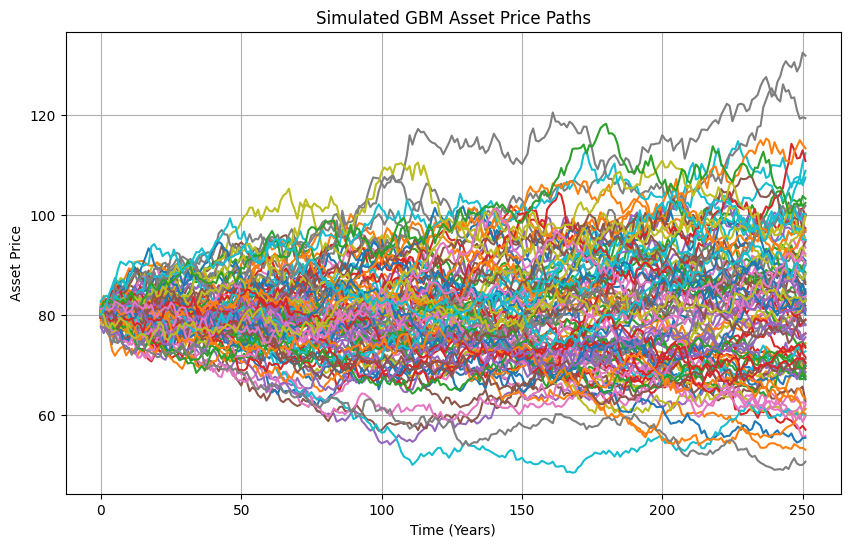

In [2]:
nsim = 100          
nstep = 252       
t1 = 0            
t2 = 1.0          
s_0 = 80        
r = 0.04         
q = 0.0          
v = 0.2          

price_paths = generate_gbm_paths(nsim, nstep, t1, t2, s_0, r, q, v)
#price_paths = generate_heston_paths(nsim, nstep, t1, t2, s_0, r, q, v, theta, rho, kappa, sigma, **kwargs)

plt.figure(figsize=(10, 6))
plt.plot(price_paths.T)
plt.title('Simulated GBM Asset Price Paths')
plt.xlabel('Time (Years)')
plt.ylabel('Asset Price')
plt.grid(True)
plt.show()

In [3]:
K = 100 
price_paths = generate_gbm_paths(nsim=15000, nstep=nstep, t1=t1, t2=t2, s_0=s_0, r=r, q=q, v=v)
env = Environment(price_paths=price_paths, K=K, t1=t1, t2=t2, r=r, option_type="put")
obs = env.reset()
print(f"Initial Observation: {obs}")

# done = False
# step_count = 0
# while not done:
#     action = env.action_space.sample() 
#     obs, reward, done, info = env.step(action)
#     step_count += 1
#     print(f"Step {step_count}: Obs={obs}, Reward={reward}, Done={done}, Info={info}")


Initial Observation: [ 2.062221  -0.6049859 -0.6124215 -0.6394381 -0.6394381  0.4340625]


In [4]:
agent = Agent(
    obssize=6,  
    actsize=2,
    hidden_dim=128,
    depth=2,
    lr=1e-3,
    buffer_size=10000,
    batch_size=128,
    gamma=0.999,
    eps_start=1.0,
    eps_min=0.01,
    eps_decay=0.995
)
agent.initialize_buffer(env, steps=100000)  

In [5]:
# Train the agent
episodes = 10000
update_target_every = 50
rewards = train(agent, env, episodes, update_target_every)


Episode 0/10000, Total Reward: 19.65, Moving Avg Reward: 19.65, Moving Avg Holding: 3.00, Epsilon: 0.9950
Episode 100/10000, Total Reward: 21.04, Moving Avg Reward: 19.89, Moving Avg Holding: 1.66, Epsilon: 0.6027
Episode 200/10000, Total Reward: 20.09, Moving Avg Reward: 19.94, Moving Avg Holding: 1.55, Epsilon: 0.3651
Episode 300/10000, Total Reward: 20.26, Moving Avg Reward: 19.91, Moving Avg Holding: 2.81, Epsilon: 0.2212
Episode 400/10000, Total Reward: 20.63, Moving Avg Reward: 19.81, Moving Avg Holding: 3.45, Epsilon: 0.1340
Episode 500/10000, Total Reward: 19.94, Moving Avg Reward: 19.79, Moving Avg Holding: 6.81, Epsilon: 0.0812
Episode 600/10000, Total Reward: 20.10, Moving Avg Reward: 19.88, Moving Avg Holding: 1.21, Epsilon: 0.0492
Episode 700/10000, Total Reward: 19.47, Moving Avg Reward: 20.12, Moving Avg Holding: 2.13, Epsilon: 0.0298
Episode 800/10000, Total Reward: 20.94, Moving Avg Reward: 19.85, Moving Avg Holding: 2.49, Epsilon: 0.0180
Episode 900/10000, Total Rewar

KeyboardInterrupt: 

In [ ]:
np.mean(rewards[:-1000])

/Users/GuidoDeFilippo/miniforge3/envs/myDLenv/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/GuidoDeFilippo/miniforge3/envs/myDLenv/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


nan

In [6]:
def plot_exercise_boundary(agent, env, n_paths=100, strike_price=150):
    """
    Visualize the early exercise boundary for a sample of paths.
    """
    plt.figure(figsize=(12, 8))
    exercise_points = []

    for i in range(n_paths):
        state = env.reset()
        path = [state[0]]  # Asset prices
        times = [0]  # Time steps
        done = False

        while not done:
            # Select an action using a greedy policy
            action = agent.act(state)

            if action == 1:  # Exercise
                exercise_points.append((env.current_step * env.dt, state[0]))  # Record exercise point
                done = True
            else:
                obs, _, done, _ = env.step(0) 
                state = obs  
                path.append(state[0]) 
                times.append(env.current_step * env.dt)

        # Plot the asset price path
        plt.plot(times, path, color='blue', alpha=0.3)

    # Plot exercise points if available
    if exercise_points:
        ex_times, ex_prices = zip(*exercise_points)
        plt.scatter(ex_times, ex_prices, color='red', label='Exercise Points')

    # Add strike price for reference
    plt.axhline(y=strike_price, color='green', linestyle='--', label='Strike Price')

    plt.title(f"Early Exercise Boundary Visualization ({n_paths} Paths)")
    plt.xlabel("Time (Years)")
    plt.ylabel("Asset Price")
    plt.legend()
    plt.grid(True)
    plt.show()

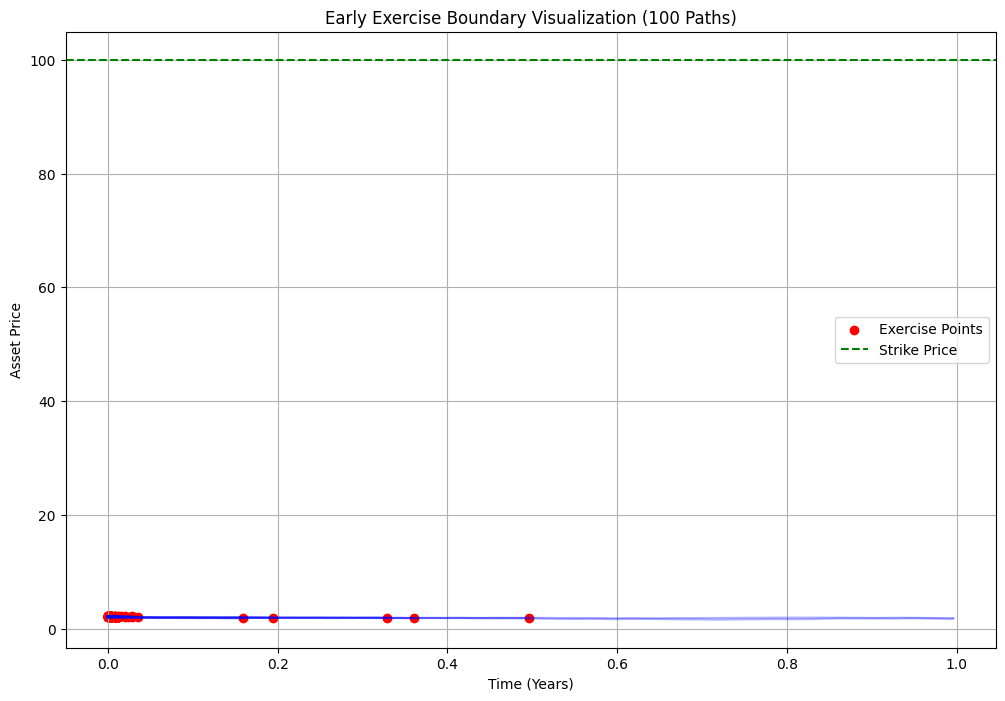

In [7]:
plot_exercise_boundary(agent, env, n_paths=100, strike_price=K)

In [8]:
def estimate_option_price(agent, env, n_paths=10000):
    """
    Estimate the option price using the trained agent.
    """
    total_rewards = []

    for _ in range(n_paths):
        state = env.reset()
        total_reward = 0
        done = False

        while not done:
            action = agent.act(state)
            next_state, reward, done, _ = env.step(action)
            total_reward += reward
            state = next_state

        total_rewards.append(total_reward)

    # Return the average reward as the estimated price
    return np.mean(total_rewards)

In [9]:
estimate_option_price(agent, env, n_paths = 1000)

19.98575164334631

In [10]:
def get_mc_price(prices, t1, t2, payoff_func, K, r):
    nstep = prices.shape[1]
    dt = (t2 - t1) / nstep
    discount = np.exp(-r * dt)
    option_values = payoff_func(prices[:, -1], K)

    for t in range(nstep - 2, -1, -1):
        intrinsic_values = payoff_func(prices[:, t], K)
        in_the_money = intrinsic_values > 0
        X = prices[in_the_money, t]
        Y = option_values[in_the_money] * discount

        if len(X) > 0:
            A = np.vstack([np.ones_like(X), X, X**2]).T
            coeffs = np.linalg.lstsq(A, Y, rcond=None)[0]
            continuation_values = np.dot(A, coeffs)
            exercise = intrinsic_values[in_the_money] > continuation_values
            option_values[in_the_money] = np.where(
                exercise,
                intrinsic_values[in_the_money],
                option_values[in_the_money] * discount
            )
        else:
            option_values *= discount

    option_price = np.mean(option_values) * discount
    return option_price

In [11]:
def put_payoff(S, K):
    return np.maximum(K - S, 0)

mc_put_price = get_mc_price(price_paths, t1, t2, put_payoff, K, r)

mc_put_price

20.0259262660085